# Introduction

This report provides an analysis of Dota 2 game results, focusing on the win rates of different heroes across various game modes. The objective is to identify the optimal heroes for each game mode based on their win rates. The analysis was conducted using a dataset containing information on Dota 2 games, including the selected heroes, game modes, and the outcomes of these matches.

# Library imports

In [66]:
# Data/Math Library imports
import json
import pandas as pd
import numpy as np
# Plotting library imports
import matplotlib.pyplot as plt
import seaborn as sns
# Import data from UCI repository (just for getting the metadata and variable information - I am using the unzipped data manually)
from ucimlrepo import fetch_ucirepo 
# Methods
from scipy.stats import chi2_contingency, f_oneway
from itertools import combinations

# Data pre-processing

The dataset was initially cleaned and preprocessed to ensure the data was in a usable format for analysis. This process included:

1. **Handling Missing Values:** Any missing or incomplete data was handled appropriately. Specifically, rows with null values in essential columns, such as game_mode and win, were removed from the dataset.

2. **Feature Selection:** The dataset contains multiple columns representing the heroes selected during the games. For this analysis, columns relevant to hero selection (hero1, hero2, etc.) and the game mode (game_mode) were selected for further analysis.

3. **Dictionary Mapping:** To improve readability, dictionaries were created to map game mode IDs to their respective names and hero IDs to hero names.

## Data Metadata Loading

In [67]:
# fetch dataset 
dota2_games_results = fetch_ucirepo(id=367) 
  
# data (as pandas dataframes) 
X = dota2_games_results.data.features 
y = dota2_games_results.data.targets 
  
# metadata 
print(dota2_games_results.metadata) 
  
# variable information 
print(dota2_games_results.variables) 

{'uci_id': 367, 'name': 'Dota2 Games Results', 'repository_url': 'https://archive.ics.uci.edu/dataset/367/dota2+games+results', 'data_url': 'https://archive.ics.uci.edu/static/public/367/data.csv', 'abstract': 'Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses.', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 102944, 'num_features': 115, 'feature_types': [], 'demographics': [], 'target_col': ['win'], 'index_col': ['clusterid'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Sat Apr 13 2024', 'dataset_doi': '10.24432/C5W593', 'creators': ['Stephen Tridgell'], 'intro_paper': None, 'additional_info': {'summary': 'Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and wea

## Data Loading

In [68]:
train = pd.read_csv("../data/dota2Train.csv", names=dota2_games_results.data.headers)
test = pd.read_csv("../data/dota2Test.csv", names=dota2_games_results.data.headers)

# We are not going to train a model, so we can concatenate the train and test data
data = pd.concat([train, test], axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102944 entries, 0 to 10293
Columns: 117 entries, win to hero113
dtypes: int64(117)
memory usage: 92.7 MB


## Mappings of data

In order to properly visualize and understand the meaning of the data, the following mappings are imported from the API which collected the data.

In [69]:
# Load the JSON mappings
with open('../data/heroes.json', 'r') as f:
    heroes_data = json.load(f)['heroes']

with open('../data/lobbies.json', 'r') as f:
    lobbies_data = json.load(f)['lobbies']

with open('../data/mods.json', 'r') as f:
    mods_data = json.load(f)['mods']

with open('../data/regions.json', 'r') as f:
    regions_data = json.load(f)['regions']

# Create dictionaries to map ids to names
hero_dict = {hero['id']: hero['localized_name'] for hero in heroes_data}
hero_dict[24] = 'Hero24 (Unknown)' # Hero24 is missing from the JSON file
lobby_dict = {lobby['id']: lobby['name'] for lobby in lobbies_data}
mod_dict = {mod['id']: mod['name'] for mod in mods_data}
region_dict = {region['id']: region['name'] for region in regions_data}

## Data exploration

The dataset contains information on Dota 2 games, including the selected heroes, game modes, and the outcomes of these matches.

For the purpose of this analysis, a few base statistics are calculated and visualized to understand the data better.

# Questions

- Is there a significant difference in win rates based on the game mode?
    - Which game mode has the highest win rate?
- Do certain heroes have a higher win rate than others?
    - If so, which heroes have the highest win rate?
- Are Certain Heroes More Likely to Win in Specific Game Modes?
- Does a Specific Region (Cluster) Influence the Win Rate?
- Do Certain Combinations of Heroes Lead to Higher Win Rates?
- Is There an Optimal Hero for Each Game Mode?

# Analysis

## Is there a significant difference in win rates based on the game mode?

This question will help you investigate whether the game mode significantly impacts the outcome of a game (win/loss). Since the target is categorical (win column with values 1 or -1), and the game mode is categorical as well (gamemode), this question can be explored using hypothesis testing and supported by descriptive statistics.

### Steps

...

#### Descriptive Analysis

Before diving into hypothesis testing, let's look at the win rate for each game mode. We can use bar plots and boxplots to visualize the win rates by game mode.

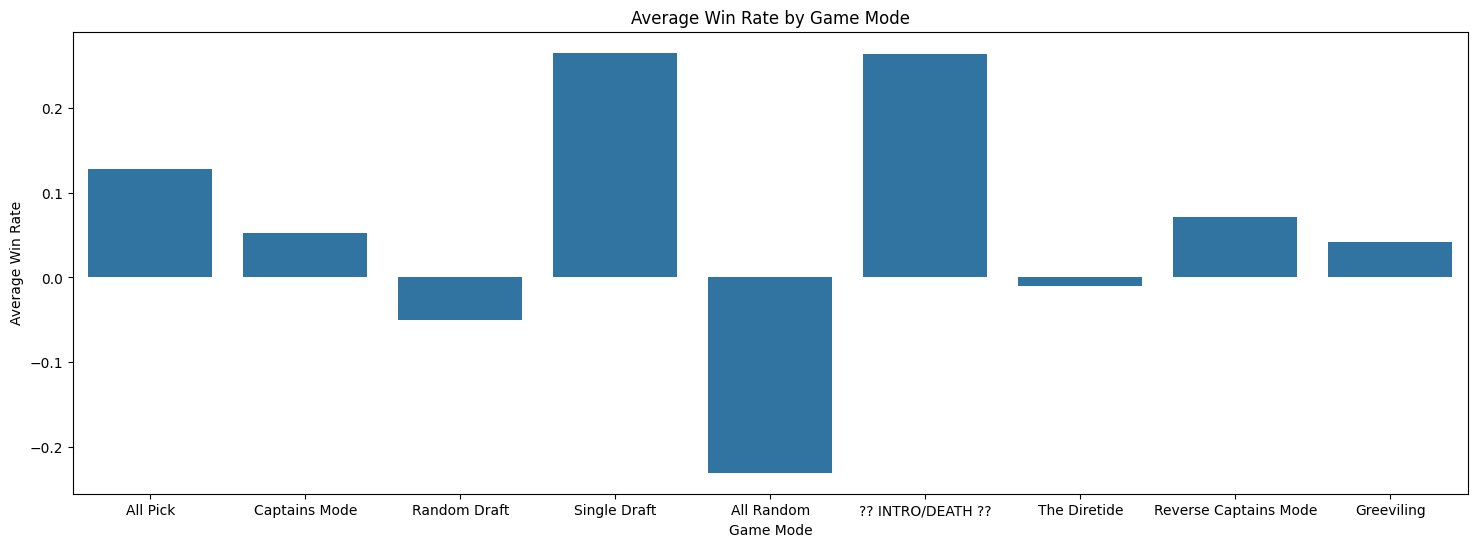

In [70]:
# Descriptive statistics
win_rate_by_gamemode = data.groupby('gamemode')['win'].mean()
# Rename index with the game mode names
win_rate_by_gamemode.index = win_rate_by_gamemode.index.map(lambda x: mod_dict[x])

# Bar plot to visualize win rates by game mode
plt.figure(figsize=(18,6))
sns.barplot(x=win_rate_by_gamemode.index, y=win_rate_by_gamemode.values)
plt.title('Average Win Rate by Game Mode')
plt.ylabel('Average Win Rate')
plt.xlabel('Game Mode')
plt.show()

#### Hypothesis Testing

To statistically test if the game mode affects win rates, we can set up a chi-square test or an ANOVA test (if treating win rates as continuous variables). Since the win rates are binary, a chi-square test for independence would be appropriate.

 - **Null Hypothesis (H0):** There is no significant difference in win rates across game modes.
 - **Alternative Hypothesis (H1):** There is a significant difference in win rates across game modes.

We can perform a chi-square test to determine whether there’s a significant association between game mode and win outcome.

In [71]:
# Creating a contingency table for game mode vs win
contingency_table = pd.crosstab(data['gamemode'], data['win'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Stat: {chi2_stat}, p-value: {p_val}")

Chi-Square Stat: 53.24662793956769, p-value: 9.66190832992202e-09


#### Correlation Coefficient

To further explore the relationship between gamemode and win, we can calculate a correlation coefficient. Since these variables are categorical, we can use Cramér’s V, which is based on the chi-square statistic.

In [72]:
def cramers_v(confusion_matrix):
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2_stat / (n * (min(r, k) - 1)))

In [73]:
# Calculate Cramer's V
cramers_v_value = cramers_v(contingency_table)
print(f"Cramer's V: {cramers_v_value}")

Cramer's V: 0.022742883942162662


#### Boxplot (Descriptive Method)

A boxplot can visually display the distribution of wins for each game mode to understand if there are any visible outliers or variations between modes.

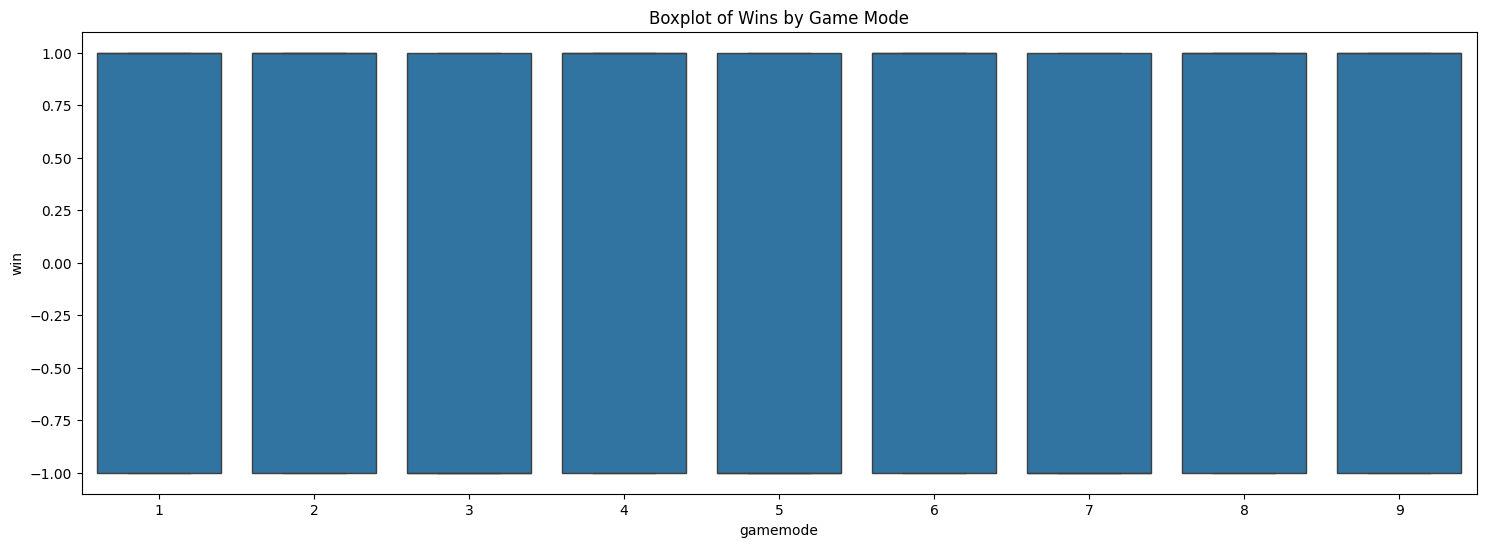

In [74]:
plt.figure(figsize=(18,6))
sns.boxplot(x='gamemode', y='win', data=data)
plt.title('Boxplot of Wins by Game Mode')
plt.show()

## Which Game Mode Has the Highest Win Rate?

To answer this, we’ll compute the average win rate for each game mode. We'll then use the mod_dict to replace the game mode IDs with descriptive labels.

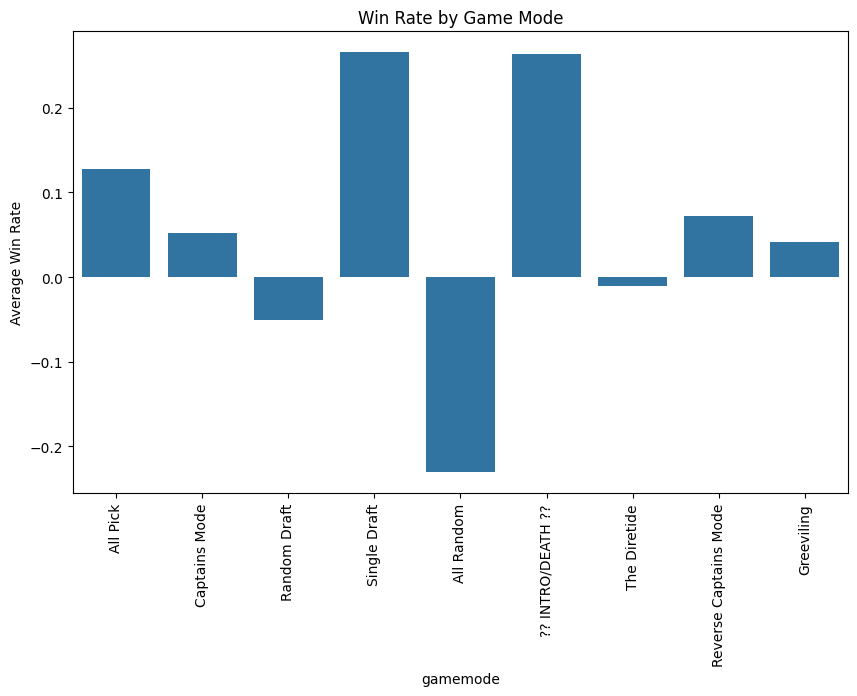

Game Mode with the Highest Win Rate: Single Draft


In [75]:
# Calculate win rate by game mode
win_rate_by_gamemode = data.groupby('gamemode')['win'].mean()

# Replace the game mode IDs with descriptive names
win_rate_by_gamemode.index = win_rate_by_gamemode.index.map(mod_dict)

# Plot the win rate by game mode
plt.figure(figsize=(10,6))
sns.barplot(x=win_rate_by_gamemode.index, y=win_rate_by_gamemode.values)
plt.title('Win Rate by Game Mode')
plt.ylabel('Average Win Rate')
plt.xticks(rotation=90)
plt.show()

# Show the game mode with the highest win rate
highest_win_rate_mode = win_rate_by_gamemode.idxmax()
print(f"Game Mode with the Highest Win Rate: {highest_win_rate_mode}")

## Do Certain Heroes Have a Higher Win Rate Than Others?

To check whether certain heroes have a higher win rate, we can calculate the average win rate for each hero. We'll use the hero_dict to map hero IDs to their localized names.

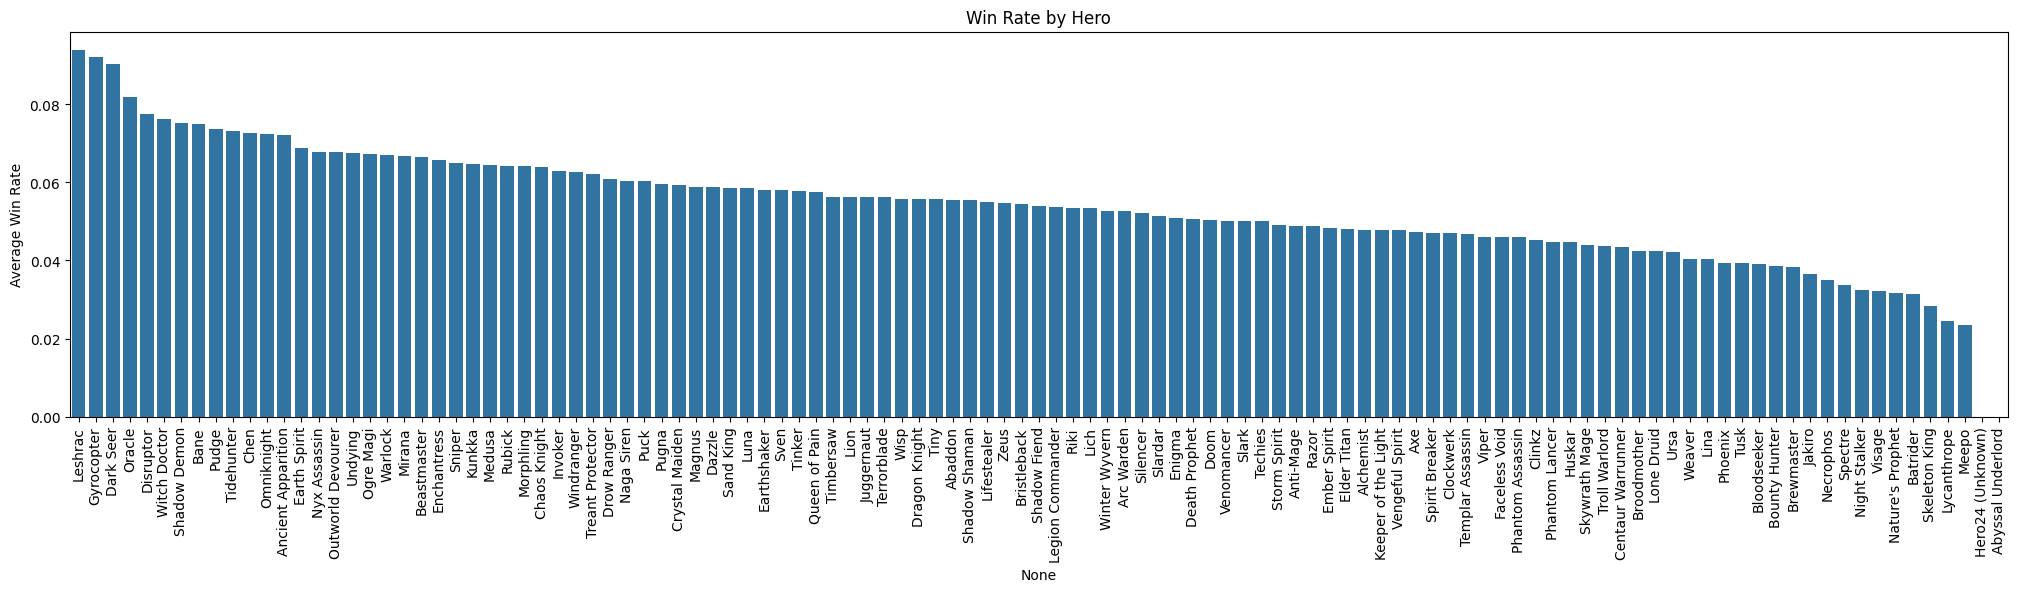

In [76]:
# Calculate win rate by each hero
hero_columns = [f'hero{i}' for i in range(1, 114)]  # Columns corresponding to heroes
win_rate_by_hero = {}

for hero_col in hero_columns:
    # Calculate win rate for each hero
    hero_presence = data[data[hero_col] != 0]
    win_rate = hero_presence['win'].mean()
    hero_id = int(hero_col.split('hero')[1])  # Extract hero id from column name
    win_rate_by_hero[hero_id] = win_rate

# Convert win_rate_by_hero to a DataFrame and map hero IDs to names
win_rate_by_hero_df = pd.DataFrame.from_dict(win_rate_by_hero, orient='index', columns=['win_rate'])
win_rate_by_hero_df.index = win_rate_by_hero_df.index.map(hero_dict)

# Sort and plot
win_rate_by_hero_df = win_rate_by_hero_df.sort_values(by='win_rate', ascending=False)

plt.figure(figsize=(25,5))
sns.barplot(x=win_rate_by_hero_df.index, y=win_rate_by_hero_df['win_rate'])
plt.xticks(rotation=90)
plt.title('Win Rate by Hero')
plt.ylabel('Average Win Rate')
plt.show()

## If So, Which Heroes Have the Highest Win Rate?

To extract the heroes with the highest win rate, we can simply use the result from the above calculation and display the top heroes.

In [77]:
# Display the top 5 heroes with highest win rates
print("Top 5 Heroes with Highest Win Rates:")
print(win_rate_by_hero_df.head(5))

Top 5 Heroes with Highest Win Rates:
            win_rate
Leshrac     0.093953
Gyrocopter  0.092025
Dark Seer   0.090427
Oracle      0.081800
Disruptor   0.077426


## Are Certain Heroes More Likely to Win in Specific Game Modes?

To explore whether certain heroes perform better in specific game modes, we can calculate the win rate for each hero within each game mode. This will allow us to check if certain heroes excel in particular game modes.

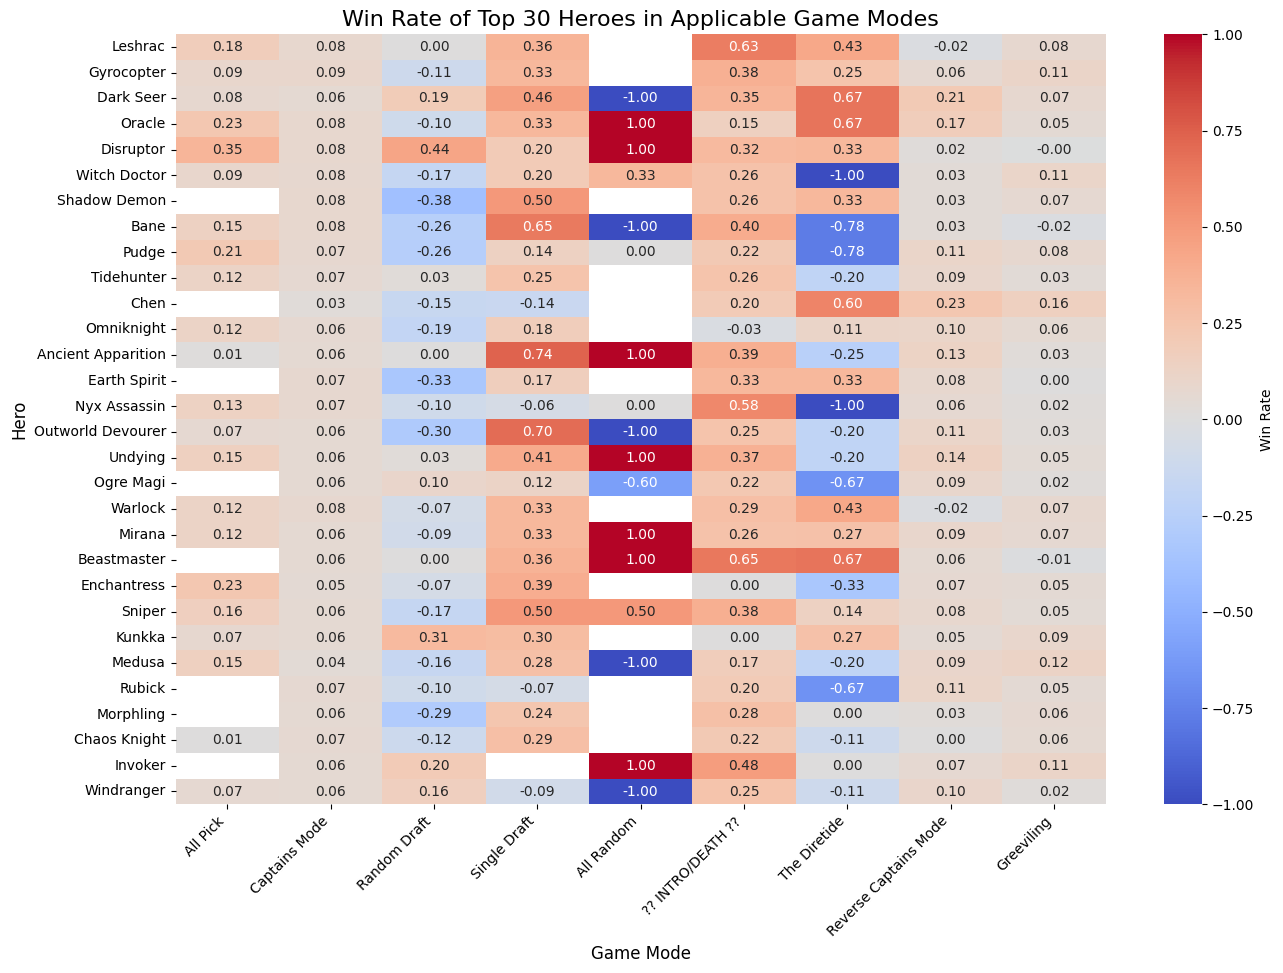

In [78]:
# Convert the results to a DataFrame for easier plotting
win_rate_by_hero_gamemode_df = pd.DataFrame(win_rate_by_hero_gamemode)

# Replace None values with np.nan using DataFrame.map
win_rate_by_hero_gamemode_df = win_rate_by_hero_gamemode_df.map(lambda x: np.nan if x is None else x)

# Filter top 30 heroes based on overall win rate
top_heroes = win_rate_by_hero_df.head(30).index.tolist()

# Filter the data for only these top heroes
win_rate_by_hero_gamemode_filtered = win_rate_by_hero_gamemode_df.loc[top_heroes, :]

# Drop game modes (columns) that contain only NaN values
win_rate_by_hero_gamemode_filtered = win_rate_by_hero_gamemode_filtered.dropna(axis=1, how='all')

# Mask the NaN values for the heatmap
mask_filtered = win_rate_by_hero_gamemode_filtered.isnull()

# Plot the heatmap for the top 30 heroes in applicable game modes
plt.figure(figsize=(15,10))  # Increase the figure size for better readability
sns.heatmap(win_rate_by_hero_gamemode_filtered, cmap='coolwarm', annot=True, fmt='.2f', mask=mask_filtered, cbar_kws={'label': 'Win Rate'})
plt.title('Win Rate of Top 30 Heroes in Applicable Game Modes', fontsize=16)
plt.ylabel('Hero', fontsize=12)
plt.xlabel('Game Mode', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and adjust x-axis labels
plt.yticks(fontsize=10)
plt.show()

## Does a Specific Region (Cluster) Influence the Win Rate?

To analyze if a specific region (cluster) affects the win rate, we can perform a one-way ANOVA test. This test helps us determine if there is a statistically significant difference in win rates across different regions.

**Steps:**
 - Group the data by region (`clusterid`) and calculate the average win rate for each.
 - Perform a one-way ANOVA to see if the differences in win rates across regions are significant.

In [79]:
# Group the data by region and calculate the average win rate for each cluster
win_rate_by_region = data.groupby('clusterid')['win'].mean()

# List of win rates for each region (cluster)
region_win_rates = [train[train['clusterid'] == region]['win'] for region in win_rate_by_region.index]

# Perform one-way ANOVA test
f_stat, p_val = f_oneway(*region_win_rates)

# Print the ANOVA test result
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_val}")

# Interpret the result
if p_val < 0.05:
    print("There is a significant difference in win rates across regions (clusters).")
else:
    print("There is no significant difference in win rates across regions (clusters).")

ANOVA F-statistic: 1.1109328658741748, p-value: 0.280184872184128
There is no significant difference in win rates across regions (clusters).


## Do Certain Combinations of Heroes Lead to Higher Win Rates?

To analyze if specific hero combinations lead to higher win rates, we can calculate the win rate for different hero pairings (from the same team). We'll focus on the co-occurrence of two heroes in the same match and check their combined win rate.

**Steps:**

 - Identify hero pairs that appear together in matches.
 - Calculate the win rate when both heroes are picked for the same team.

Top 10 Hero Combinations with Highest Win Rates:
                             win_rate
(Chen, Arc Warden)           0.714286
(Chen, Wisp)                 0.600000
(Chen, Techies)              0.377778
(Brewmaster, Wisp)           0.350000
(Lone Druid, Phoenix)        0.333333
(Chen, Brewmaster)           0.333333
(Leshrac, Techies)           0.313725
(Dark Seer, Wisp)            0.312500
(Vengeful Spirit, Visage)    0.306667
(Chen, Keeper of the Light)  0.300000


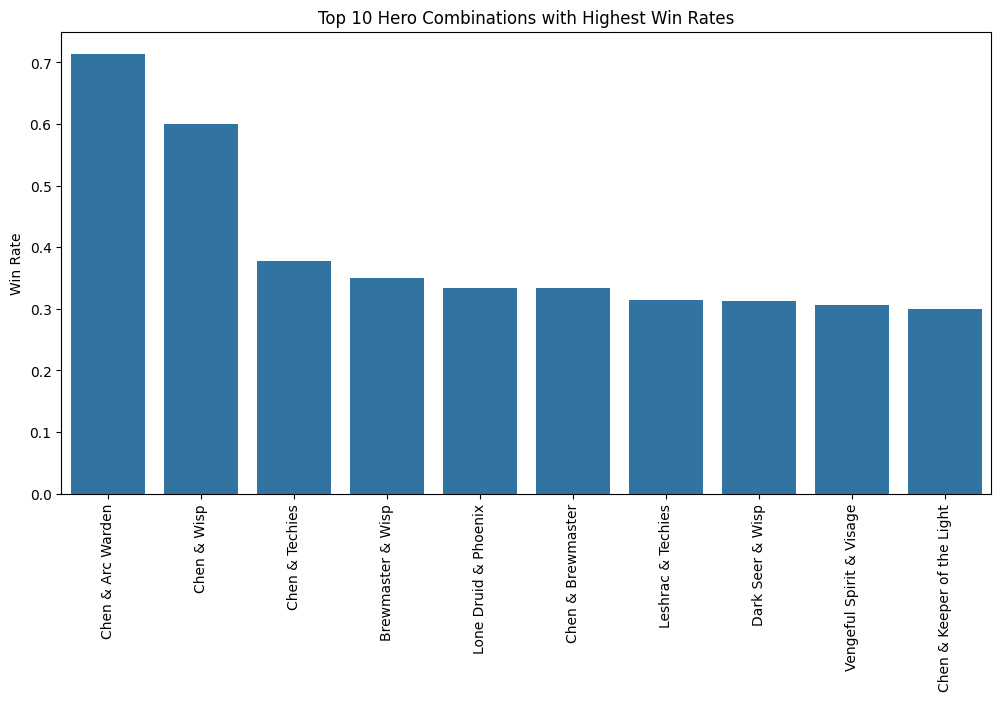

In [80]:
# Create a dictionary to store the win rates for hero pairs
hero_combinations = {}

# Iterate over all hero pairs (combinations of 2)
for hero_pair in combinations(hero_columns, 2):
    hero1, hero2 = hero_pair
    # Get matches where both heroes were picked by the same team
    hero_team_picks = data[(data[hero1] != 0) & (data[hero2] != 0)]
    
    if not hero_team_picks.empty:
        # Calculate win rate for this hero pair
        win_rate = hero_team_picks['win'].mean()
        hero_combinations[(hero1, hero2)] = win_rate

# Convert hero combinations to a DataFrame
hero_combinations_df = pd.DataFrame.from_dict(hero_combinations, orient='index', columns=['win_rate'])

# Sort by win rate
hero_combinations_df = hero_combinations_df.sort_values(by='win_rate', ascending=False)

# Map hero IDs to names
hero_combinations_df.index = [(hero_dict[int(hero.split('hero')[1])], hero_dict[int(hero2.split('hero')[1])]) for hero, hero2 in hero_combinations_df.index]

# Display top 10 hero combinations with highest win rates
print("Top 10 Hero Combinations with Highest Win Rates:")
print(hero_combinations_df.head(10))

# Plot the top 10 combinations
plt.figure(figsize=(12,6))
sns.barplot(x=[f'{hero1} & {hero2}' for hero1, hero2 in hero_combinations_df.head(10).index], y=hero_combinations_df['win_rate'].head(10))
plt.title('Top 10 Hero Combinations with Highest Win Rates')
plt.xticks(rotation=90)
plt.ylabel('Win Rate')
plt.show()

## Is There an Optimal Hero for Each Game Mode?

To determine if a hero performs best in a particular game mode, we will calculate the win rate of each hero for each game mode and identify the highest-performing hero within each game mode.

**Steps:**

 - For each game mode, calculate the win rate for each hero.
 - Identify the hero with the highest win rate for each game mode.

In [81]:
# Create a dictionary to store optimal heroes for each game mode
optimal_heroes = {}

# Loop over each game mode
for mod_id, mod_name in mod_dict.items():
    win_rate_by_hero_in_mode = {}
    
    # For each hero, calculate win rate within this game mode
    for hero_col in hero_columns:
        mode_data = data[data['gamemode'] == mod_id]
        hero_data = mode_data[mode_data[hero_col] != 0]
        
        if not hero_data.empty:
            win_rate = hero_data['win'].mean()
        else:
            win_rate = None  # No data for this hero in this mode
        
        hero_id = int(hero_col.split('hero')[1])
        win_rate_by_hero_in_mode[hero_dict.get(hero_id, f'Hero {hero_id}')] = win_rate
    
    # Filter out None values before finding the hero with the highest win rate
    filtered_win_rate_by_hero = {hero: rate for hero, rate in win_rate_by_hero_in_mode.items() if rate is not None}
    
    if filtered_win_rate_by_hero:  # Check if there are valid win rates
        optimal_hero = max(filtered_win_rate_by_hero, key=filtered_win_rate_by_hero.get)
        optimal_heroes[mod_name] = optimal_hero
    else:
        optimal_heroes[mod_name] = None  # If no valid win rate, mark as None

# Display the optimal heroes for each game mode
print("Optimal heroes for each game mode:")
for mode, hero in optimal_heroes.items():
    if hero is not None:
        print(f"{mode}: {hero}")
    else:
        print(f"{mode}: No data available")

Optimal heroes for each game mode:
Unknown: No data available
All Pick: Disruptor
Captains Mode: Bane
Random Draft: Wisp
Single Draft: Ancient Apparition
All Random: Axe
?? INTRO/DEATH ??: Treant Protector
The Diretide: Brewmaster
Reverse Captains Mode: Chen
Greeviling: Chen
Tutorial: No data available
Mid Only: No data available
Least Played: No data available
New Player Pool: No data available
Compendium Matchmaking: No data available
Custom: No data available
Captains Draft: No data available
Balanced Draft: No data available
Ability Draft: No data available
?? Event ??: No data available
All Random Death Match: No data available
1vs1 Solo Mid: No data available
Ranked All Pick: No data available
